# 1D kinematic driver with time-dependent aerosol injection

Author: Jatan Buch (v1, 240424) || (v2, 240429)

In [1]:
from case_files.settings_time import Settings 
from case_files.simulation_sd_update import Simulation
import numpy as np
import xarray
from tqdm import tqdm
from PySDM.initialisation.equilibrate_wet_radii import equilibrate_wet_radii

from PySDM import Formulae
from PySDM.initialisation.spectra import Lognormal
from PySDM.physics import si
from PySDM.exporters import NetCDFExporter_1d
from collections import namedtuple

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import matplotlib.path as mpltPath
from utils.plot_params_mpl39 import params
import matplotlib.pylab as pylab
import seaborn as sns
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']
from utils.plot_rates import plot_ax

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

/Users/hyfives-lamont/Desktop/cloud_seeding/PySDM/PySDM/backends/impl_numba/conf.py:19: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(


## Case setup

In [2]:
common_params = {
    "t_max": 60 * si.minutes,
    "n_sd_per_mode": (32,),
    "aerosol_modes_by_kappa": {
            .3: Lognormal(
                        norm_factor= 10 / si.cm ** 3,
                        m_mode= 1E2 * si.nm,
                        s_geom=1.4
                ),
            },
    "dt": 5 * si.s,
    "dz": 50 * si.m,
    "p0": 990 * si.hPa,
    "z_part": ((0., 1.),),
    "n_seed_sds": 1,
    "r_seed": 10 * si.um,
    "kappa_seed": 0.85,
    "m_param": 1e11,
    "seed_z_part": (0., 1.),
    "t_part": (0* si.minutes, 15* si.minutes) 
}

In [8]:
rate_unit = "s$^{-1}$ kg$^{-1}$"
contour_lev = [.4]
rho_times_w= 2 * si.kg/si.m**3 * si.m/si.s

kwargs = {
    'coll_rate': {'cmin': 100, 'cmax': 1e6, 'var': 'collision_rate',   'qlabel': f'collision rate [{rate_unit}]', 'clog': True}, 
    'coal_rate': {'cmin': 100, 'cmax': 1e6, 'var': 'coalescence_rate', 'qlabel': f'coalescence rate [{rate_unit}]', 'clog': True},
}
contour_args = {
    'contour_var1': 'cloud water mixing ratio', 'contour_lvl1': contour_lev,
    'contour_var2': 'rain water mixing ratio', 'contour_lvl2': contour_lev
}

def fig_ax():
    return plt.subplots(nrows=1, ncols=1, figsize=(8,6))

In [3]:
def stepwise_sd_update(simobj, n_steps, seed_step, seed_z_part, seed_r, seed_m, seed_kappa):

    cell_edge_arr= np.linspace(simobj.particulator.attributes['position in cell'].data[0, :].min(), \
                        simobj.particulator.attributes['position in cell'].data[0, :].max(), 73)
    ncell_arr= np.digitize(simobj.particulator.attributes['position in cell'].data[0, :], cell_edge_arr) - 1
    
    simobj.save(0)
    for i in range(n_steps):

        if i in seed_step:
            try:
                potseed_arr= np.where(np.abs(simobj.particulator.attributes['radius'].data - seed_r) < seed_r/2)[0]
                potindx_arr= np.where((simobj.particulator.attributes['position in cell'].data[0, potseed_arr] > seed_z_part[0]) & \
                                    (simobj.particulator.attributes['position in cell'].data[0, potseed_arr] <= seed_z_part[1]))[0]
                potseed= np.random.choice(potseed_arr[potindx_arr], 1)[0]
                
                npotseed_arr= np.where(ncell_arr == ncell_arr[potseed])[0]
                npotseed_arr= npotseed_arr[npotseed_arr != potseed]

                cellpos= simobj.particulator.attributes['position in cell'].data[0, potseed]
                simobj.particulator.attributes['multiplicity'].data[potseed]+= seed_m
                simobj.particulator.attributes['kappa times dry volume'].data[potseed]= simobj.particulator.attributes['dry volume'].data[potseed]*seed_kappa
                simobj.particulator.attributes['water mass'].data[npotseed_arr]+= simobj.particulator.attributes['water mass'].data[potseed]/len(npotseed_arr)
                simobj.particulator.attributes['water mass'].data[potseed]= simobj.particulator.attributes['water mass'].data[potseed]/len(npotseed_arr) #simobj.particulator.formulae.particle_shape_and_density.volume_to_mass(simobj.env.formulae.trivia.volume(radius=seed_r))
            except:
                potseed_arr= np.where(np.abs(simobj.particulator.attributes['radius'].data - seed_r) < seed_r)[0]
                potseed_arr= np.where((simobj.particulator.attributes['position in cell'].data[0, potseed_arr] > seed_z_part[0]) & \
                                    (simobj.particulator.attributes['position in cell'].data[0, potseed_arr] <= seed_z_part[1]))[0]
                potseed= np.random.choice(potseed_arr[potindx_arr], 1)[0]
                
                npotseed_arr= np.where(ncell_arr == ncell_arr[potseed])[0]
                npotseed_arr= npotseed_arr[npotseed_arr != potseed]

                cellpos= simobj.particulator.attributes['position in cell'].data[0, potseed]
                simobj.particulator.attributes['multiplicity'].data[potseed]+= seed_m
                simobj.particulator.attributes['kappa times dry volume'].data[potseed]= simobj.particulator.attributes['dry volume'].data[potseed]*seed_kappa
                simobj.particulator.attributes['water mass'].data[npotseed_arr]+= simobj.particulator.attributes['water mass'].data[potseed]/len(npotseed_arr)
                simobj.particulator.attributes['water mass'].data[potseed]= simobj.particulator.attributes['water mass'].data[potseed]/len(npotseed_arr) #simobj.particulator.formulae.particle_shape_and_density.volume_to_mass(simobj.env.formulae.trivia.volume(radius=seed_r))
        
        simobj.mpdata.update_advector_field()
        if "Displacement" in simobj.particulator.dynamics:
            simobj.particulator.dynamics["Displacement"].upload_courant_field(
                (simobj.mpdata.advector / simobj.g_factor_vec,)
            )
        simobj.particulator.run(steps=1)

        simobj.save(i+1)
    
    Outputs = namedtuple("Outputs", "products attributes")
    output_results = Outputs(simobj.output_products, simobj.output_attributes)
    return output_results, potseed, cellpos

### sandbox 1

In [27]:
output = {}
settings = {}
simulation = {}
rho_times_w= 2 * si.kg/si.m**3 * si.m/si.s

key = f"rhow={rho_times_w}"
settings[key] = Settings(
        **common_params,
        formulae= Formulae(seed= np.random.randint(1000)),
        rho_times_w_1=rho_times_w,
        precip= True
        )
simulation[key] = Simulation(settings[key])

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


In [29]:
simulation[key].save(0)
for i in range(100):
    simulation[key].mpdata.update_advector_field()
    if "Displacement" in simulation[key].particulator.dynamics:
        simulation[key].particulator.dynamics["Displacement"].upload_courant_field(
                (simulation[key].mpdata.advector / simulation[key].g_factor_vec,)
        )
    simulation[key].particulator.run(steps=1)

    simulation[key].save(i+1)

In [30]:
cell_edge_arr= np.linspace(simulation[key].particulator.attributes['position in cell'].data[0, :].min(), \
                        simulation[key].particulator.attributes['position in cell'].data[0, :].max(), settings[key].nz)
ncell_arr= np.digitize(simulation[key].particulator.attributes['position in cell'].data[0, :], cell_edge_arr) - 1

potseed_arr= np.where(np.abs(simulation[key].particulator.attributes['radius'].data - 1*si.um) < 1*si.um/2)[0]
potindx_arr= np.where((simulation[key].particulator.attributes['position in cell'].data[0, potseed_arr] > 0) \
         & (simulation[key].particulator.attributes['position in cell'][0, potseed_arr] <= 0.25))[0]
potseed= np.random.choice(potseed_arr[potindx_arr], 1)[0]

npotseed_arr= np.where(ncell_arr == ncell_arr[potseed])[0]
npotseed_arr= npotseed_arr[npotseed_arr != potseed]

In [31]:
simulation[key].particulator.attributes['position in cell'].data[0, potseed], simulation[key].particulator.attributes['multiplicity'].data[potseed], \
            simulation[key].particulator.attributes['water mass'].data[potseed]

(0.18561298854772112, 17787359, 1.1716381417474549e-15)

In [32]:
simulation[key].particulator.attributes['multiplicity'].data[potseed]+= 1e9
simulation[key].particulator.attributes['water mass'].data[npotseed_arr]+= \
                simulation[key].particulator.attributes['water mass'].data[potseed]/len(npotseed_arr)
simulation[key].particulator.attributes['water mass'].data[potseed]= simulation[key].particulator.attributes['water mass'].data[potseed]/len(npotseed_arr)

In [33]:
simulation[key].particulator.attributes['multiplicity'].data[potseed], simulation[key].particulator.attributes['water mass'].data[potseed]

(1017787359, 3.347537547849871e-17)

In [34]:
for i in range(100):
    simulation[key].mpdata.update_advector_field()
    if "Displacement" in simulation[key].particulator.dynamics:
        simulation[key].particulator.dynamics["Displacement"].upload_courant_field(
                (simulation[key].mpdata.advector / simulation[key].g_factor_vec,)
        )
    simulation[key].particulator.run(steps=1)

    simulation[key].save(i+1)

In [35]:
simulation[key].particulator.attributes['position in cell'].data[0, potseed], simulation[key].particulator.attributes['multiplicity'].data[potseed], \
                simulation[key].particulator.attributes['water mass'].data[potseed]

(0.9840356674733192, 476597177, 2.8906348129943124e-12)

### sandbox 2

In [9]:
output = {}
settings = {}
simulation = {}
rho_times_w= 2 * si.kg/si.m**3 * si.m/si.s

key = f"rhow={rho_times_w}"
settings[key] = Settings(
        **common_params,
        formulae= Formulae(seed= np.random.randint(1000)),
        rho_times_w_1=rho_times_w,
        precip= True
        )
simulation[key] = Simulation(settings[key])
output[key]= stepwise_sd_update(simobj= simulation[key], n_steps= settings[key].nt, seed_step= [50, 100, 150, 200], \
                                                                    seed_z_part= settings[key].seed_z_part, seed_r= 1*si.um, seed_m= 1e10, seed_kappa= 0.85)
rain_xarr = {}
rain_xarr[key]= xarray.DataArray(data= output[key].products['rain water mixing ratio'],
                            dims=["z", "t"],
                            coords=dict(
                                t=(["t"], output[key].products['t'],),
                                z=(["z"], output[key].products['z'],),)
                            )

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


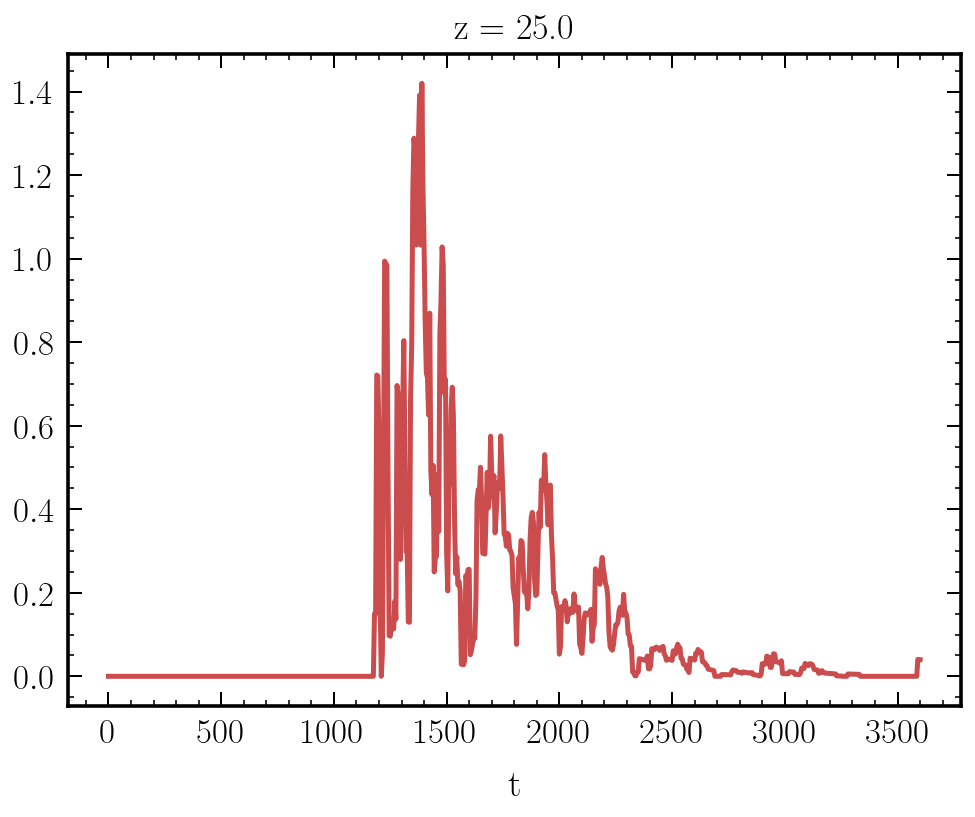

In [10]:
fig, ax= plt.subplots(1, 1, figsize=(8, 6))
rain_xarr[key].sel(z= 25).plot(ax= ax)

In [11]:
rain_xarr[key].sel(z= 25).sum()

<xarray.DataArray ()>
array(85.69539062)
Coordinates:
    z        float64 25.0

### Stochastic averaging

In [11]:
output = {}
settings = {}
simulation = {}
rain_xarr = {}
surface_rain= {}
cellpos_arr= []
arr_potseed= []

np.random.seed(67)
n_runs= 10
rho_times_w_arr= np.array([2]) * si.kg/si.m**3 * si.m/si.s
sav_flag= False

for r_id in tqdm(range(n_runs)):
    for rho_times_w in (rho_times_w_arr):
        key = f"rhow={rho_times_w}_run={r_id}"
        settings[key] = Settings(
            **common_params,
            formulae= Formulae(seed= np.random.randint(1000)),
            rho_times_w_1=rho_times_w,
            precip= True
            )
        simulation[key] = Simulation(settings[key])
        output[key], potseed, cellpos= stepwise_sd_update(simobj= simulation[key], n_steps= settings[key].nt, seed_step= [50, 100, 150, 200, 250], \
                                                                    seed_z_part= settings[key].seed_z_part, seed_r= 1*si.um, seed_m= 1e11, seed_kappa= 0.85)
        cellpos_arr.append(cellpos)
        arr_potseed.append(potseed)

        rain_xarr[key]= xarray.DataArray(data= output[key].products['rain water mixing ratio'],
                            dims=["z", "t"],
                            coords=dict(
                                t=(["t"], output[key].products['t'],),
                                z=(["z"], output[key].products['z'],),)
                            )

for rho_times_w in (rho_times_w_arr):
    key = f"rhow={rho_times_w}"
    surface_rain[key]= xarray.concat([rain_xarr[key + "_run=" + str(i)] for i in range(n_runs)], dim="run")
    surface_rain[key]= surface_rain[key].assign_coords(run=range(n_runs))

if sav_flag:
    surface_rain[key].to_netcdf("~/Desktop/cloud_seeding/sav_files/surface_rain_" + key + "_n1_10_r1_0.1_nsdbkg_32_rsd_1_logmsd_11_zseed_1.0_tseed_50_100_150_200_250.nc")

100%|██████████| 10/10 [01:21<00:00,  8.13s/it]


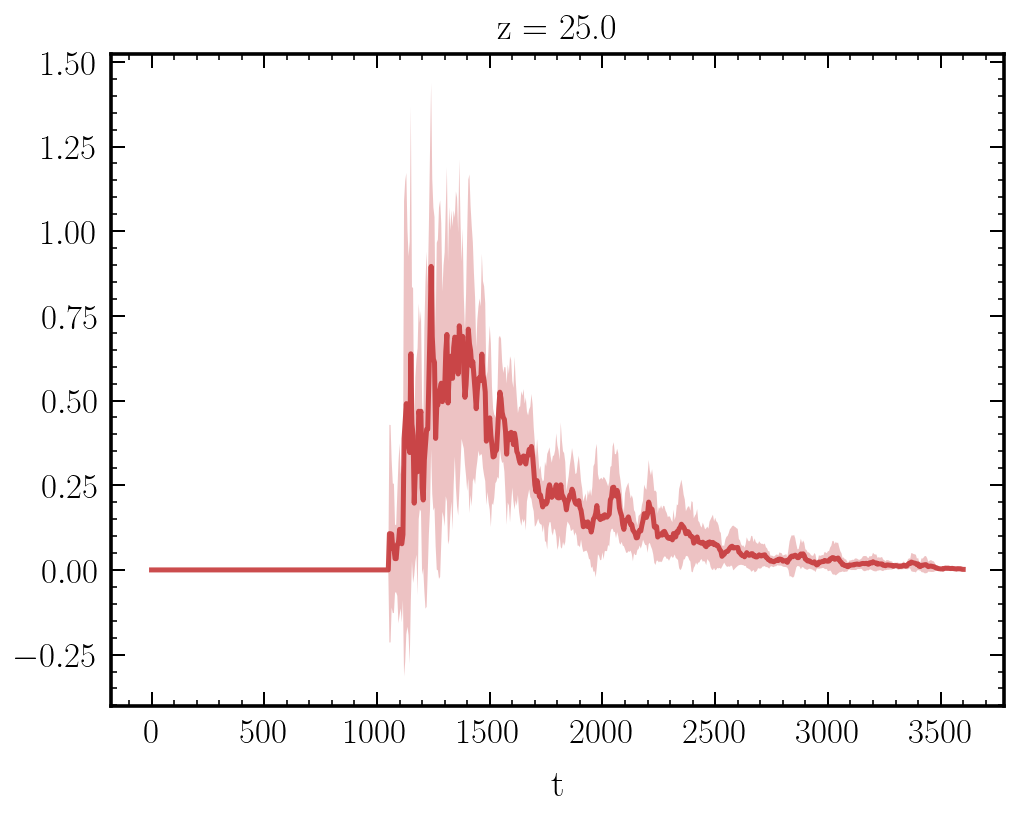

In [12]:
fig, ax= plt.subplots(1, 1, figsize=(8, 6))
surface_rain[key].sel(z= 25).mean(dim= "run").plot(ax= ax)
ax.fill_between(surface_rain[key].t, surface_rain[key].sel(z= 25).mean(dim= "run") + surface_rain[key].sel(z= 25).std(dim= "run"), \
                                        surface_rain[key].sel(z= 25).mean(dim= "run") - surface_rain[key].sel(z= 25).std(dim= "run"), alpha= 0.3)

In [13]:
surface_rain[key].sel(z= 25).sum(dim= "t").mean(dim= "run")

<xarray.DataArray ()>
array(86.30989127)
Coordinates:
    z        float64 25.0

In [14]:
surface_rain[key].sel(z= 25).sum(dim= "t")

<xarray.DataArray (run: 10)>
array([86.86013518, 85.35726121, 79.81027197, 92.47048236, 92.85819319,
       82.25884391, 85.09285703, 82.51643369, 89.56086884, 86.31356533])
Coordinates:
    z        float64 25.0
  * run      (run) int64 0 1 2 3 4 5 6 7 8 9

In [8]:
cellpos_arr, arr_potseed

([0.4175358101239543,
  0.895745074292726,
  0.9211446942507268,
  0.8647691922771172,
  0.06258664676633907,
  0.8703925710769689,
  0.8744533304170339,
  0.8323769945627277,
  0.6258043884446024,
  0.31856314463881685],
 [429, 348, 1707, 1669, 430, 2093, 639, 1963, 1552, 1866])

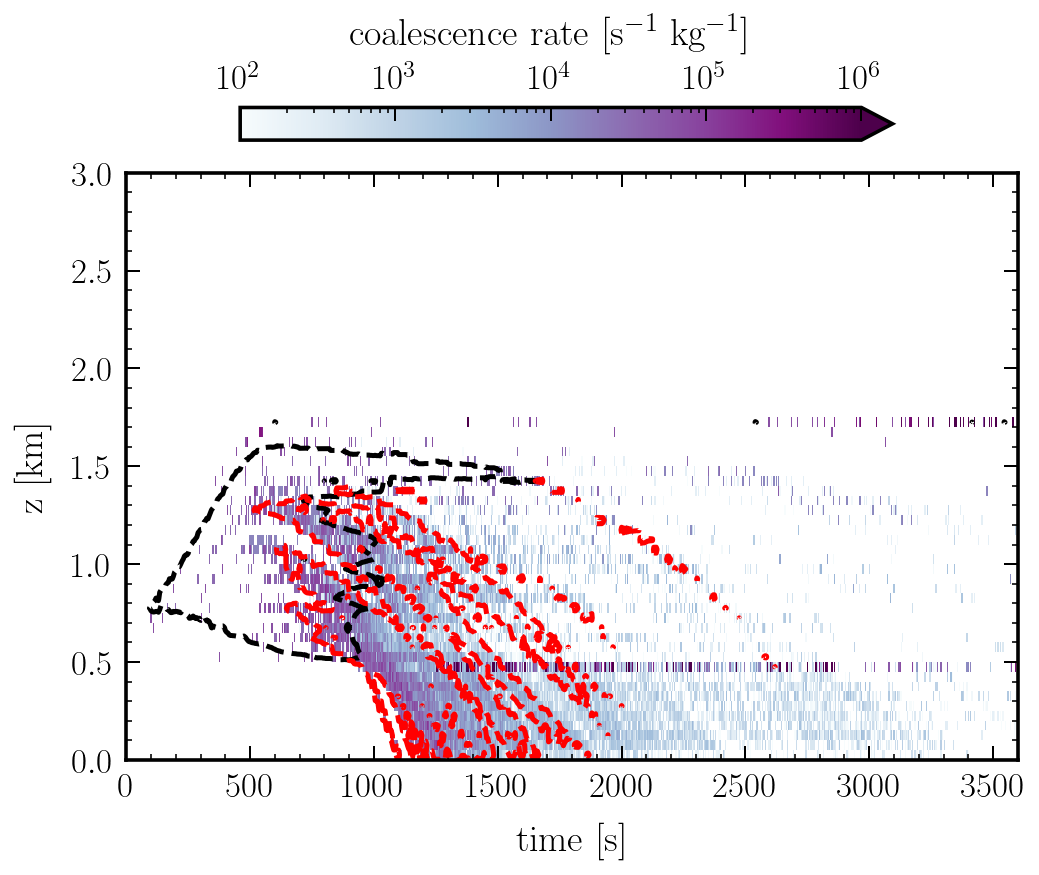

In [15]:
fig, axes = fig_ax()
plot_ax(axes, output= output[f"rhow={rho_times_w}_run={4}"].products, **contour_args, **kwargs['coal_rate'])
plt.savefig('/Users/hyfives-lamont/Desktop/cloud_seeding/plots/coal_rate_n1_10_n2_1_r2_1_rsd_1_logmsd_11_zseed_1.0_tseed_50_100_150_200_250.pdf', bbox_inches='tight', dpi= 300);

## Plotting

In [2]:
surface_rain_alt= xarray.open_dataarray("~/Desktop/cloud_seeding/sav_files/surface_rain_rhow=2.0_n1_10_r1_0.1_nsd_32.nc")
surface_rain_nsd_2040= xarray.open_dataarray("~/Desktop/cloud_seeding/sav_files/surface_rain_rhow=2.0_n1_10_r1_0.1_nsdbkg_32_rsd_10_logmsd_11_zseed_1.0_tseed_50_100_150_200_250.nc")
#surface_rain_nsd_4050= xarray.open_dataarray("../../sav_files/surface_rain_rhow=2.0_n1_50_r1_0.1_n2_10_r2_1_nsdbkg_32_m9_nsd_32_zseed_0.25_tseed_40_50.nc")

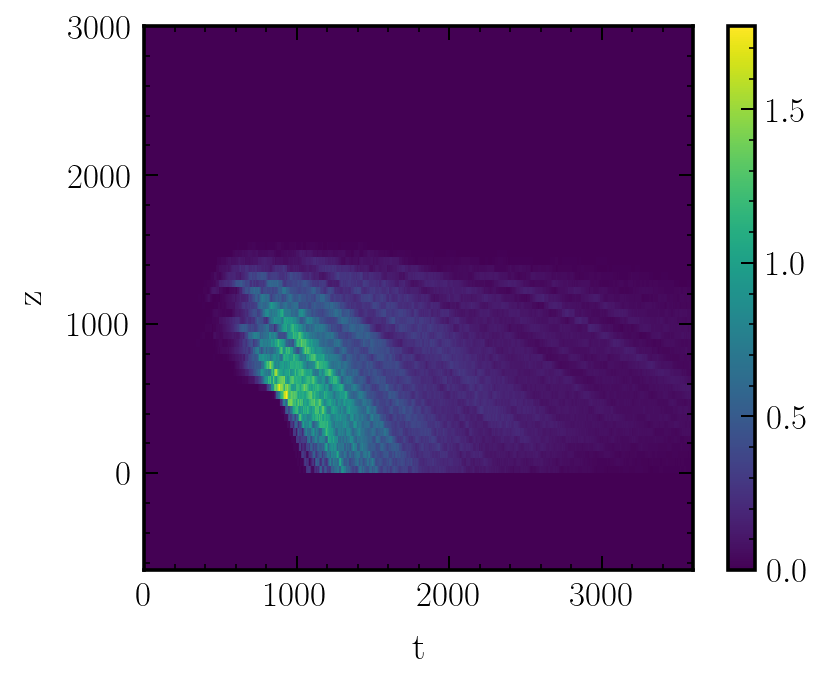

In [37]:
surface_rain_alt.mean(dim= "run").plot()

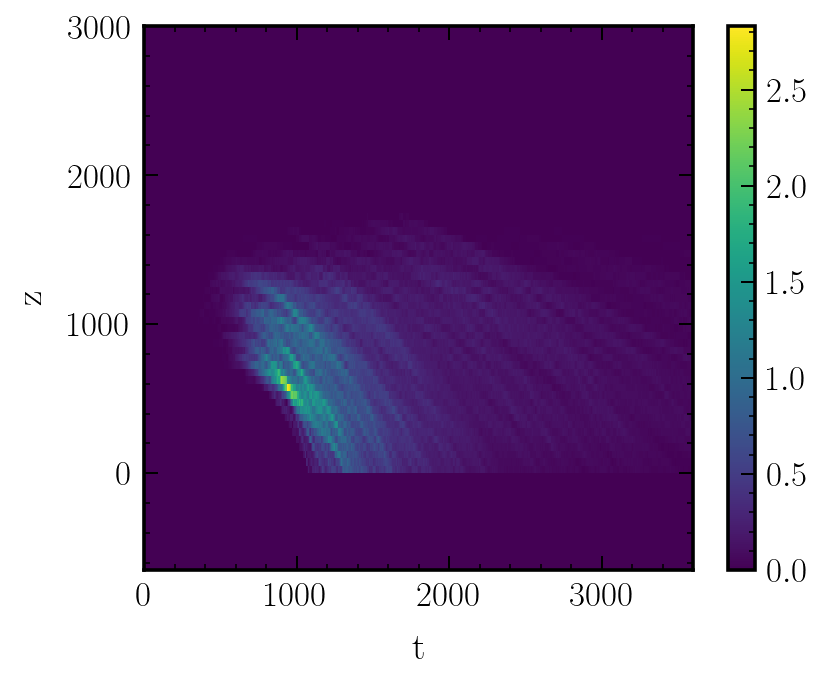

In [38]:
surface_rain_nsd_2040.mean(dim= "run").plot()

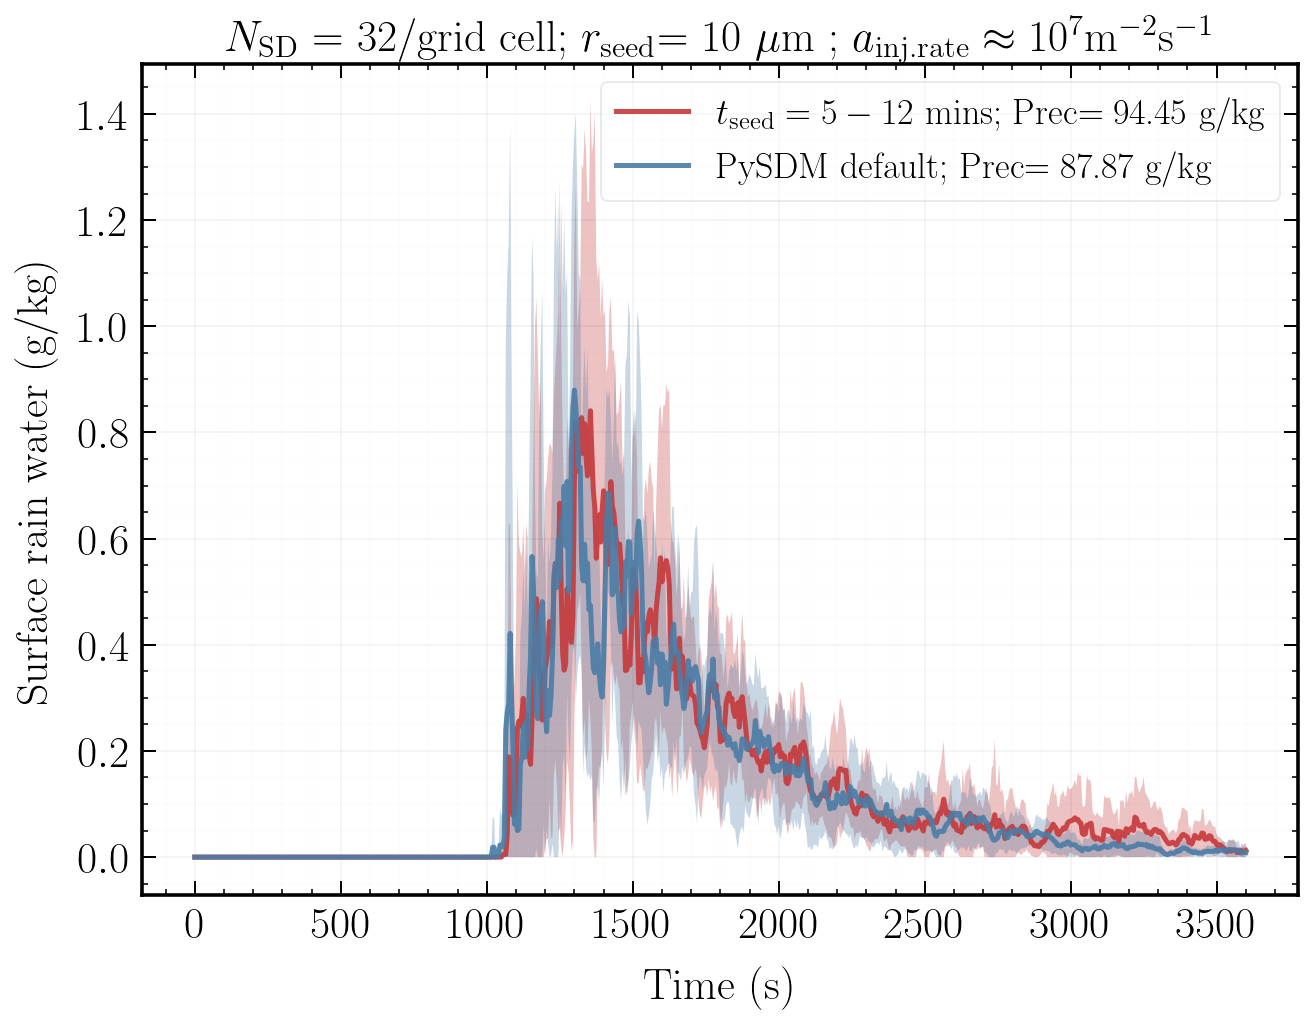

In [40]:
fig, ax= plt.subplots(1, 1, figsize= (9, 7) , constrained_layout= True)
surface_rain_nsd_2040.sel(z= 25).mean(dim= "run").plot(ax= ax, label= r'$t_{\rm seed} = 5-12$ mins; Prec= %.2f g/kg'%np.sum(surface_rain_nsd_2040.sel(z= 25).mean(dim= "run").values))
surface_rain_alt.sel(z= 25).mean(dim= "run").plot(ax= ax, label= r'PySDM default; Prec= %.2f g/kg'%np.sum(surface_rain_alt.sel(z= 25).mean(dim= "run").values))
surface_rain_n_seed= surface_rain_alt.sel(z= 25).mean(dim= "run") - surface_rain_alt.sel(z= 25).std(dim= "run")
surface_rain_n_seed[surface_rain_n_seed < 0]= 0
surface_rain_seed= surface_rain_nsd_2040.sel(z= 25).mean(dim= "run") - surface_rain_nsd_2040.sel(z= 25).std(dim= "run")
surface_rain_seed[surface_rain_seed < 0]= 0

ax.fill_between(surface_rain_nsd_2040.t, surface_rain_nsd_2040.sel(z= 25).mean(dim= "run") + surface_rain_nsd_2040.sel(z= 25).std(dim= "run"), surface_rain_seed, alpha= 0.3)
ax.fill_between(surface_rain_alt.t, surface_rain_alt.sel(z= 25).mean(dim= "run") + surface_rain_alt.sel(z= 25).std(dim= "run"), surface_rain_n_seed, alpha= 0.3)
ax.set_xlabel('Time (s)', fontsize= 22);
ax.set_ylabel('Surface rain water (g/kg)', fontsize= 22);
ax.legend(loc= 'upper right', frameon= True, fontsize= 18);

ax.set_title(r'$N_{\rm SD}$ = 32/grid cell; $r_{\rm seed}$= 10 $\mu {\rm m}$ ; $a_{\rm inj. rate} \approx 10^7 {\rm} {\rm m}^{-2} {\rm s}^{-1} $', fontsize= 22);
#ax.set_title(r'$\rho_w \times w = 2$ kg m$^{3}$ s$^{-1}$', fontsize= 22);
ax.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax.grid(visible=True, which='major', color='black', alpha=0.05, linestyle='-');
ax.grid(visible=True, which='minor', color='black', alpha=0.01, linestyle='-');

plt.savefig('/Users/hyfives-lamont/Desktop/cloud_seeding/plots/surface_rain_water_n1_10_n2_1_r2_1_rsd_10_logmsd_11_zseed_1.0_tseed_50_100_150_200_250.pdf', bbox_inches='tight', dpi= 300);

In [16]:
settings['rhow=2.0_run=0'].dz **2

2500.0

In [13]:
1e9 /(settings['rhow=2.0_run=0'].dz **2 * 5)

80000.0

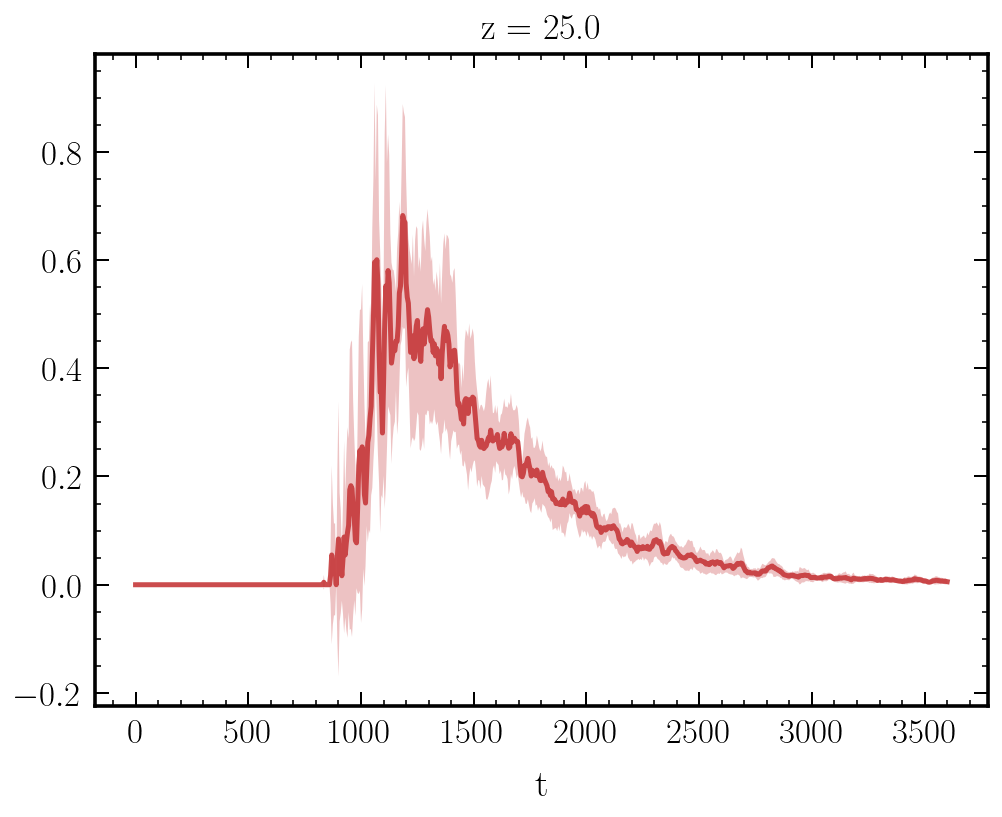

In [4]:
fig, ax= plt.subplots(1, 1, figsize=(8, 6))
surface_rain[key].sel(z= 25).mean(dim= "run").plot(ax= ax)
ax.fill_between(surface_rain[key].t, surface_rain[key].sel(z= 25).mean(dim= "run") + surface_rain[key].sel(z= 25).std(dim= "run"), \
                                        surface_rain[key].sel(z= 25).mean(dim= "run") - surface_rain[key].sel(z= 25).std(dim= "run"), alpha= 0.3)
ax.set_xlabel('Time (s)', fontsize= 22);
ax.set_ylabel('Rain water mixing ratio (g/kg)', fontsize= 22);
ax.legend(loc= 'upper right', frameon= True, fontsize= 18);

In [11]:
rain_xarr_rhow2_1= xarray.open_dataarray("../../sav_files/surface_rain_rhow=2.0_n1_50_r1_0.1_n2_50_r2_1_nsd_128_zseed_0.25.nc")
rain_xarr_rhow2_2= xarray.open_dataarray("../../sav_files/surface_rain_rhow=2.0_n1_50_r1_0.1_n2_50_r2_1_nsd_128_zseed_0.75.nc")
#rain_xarr_rhow2_3= xarray.open_dataarray("../../sav_files/surface_rain_rhow=2.0_n1_50_r1_0.1_n2_50_r2_1_nsd_32.nc")

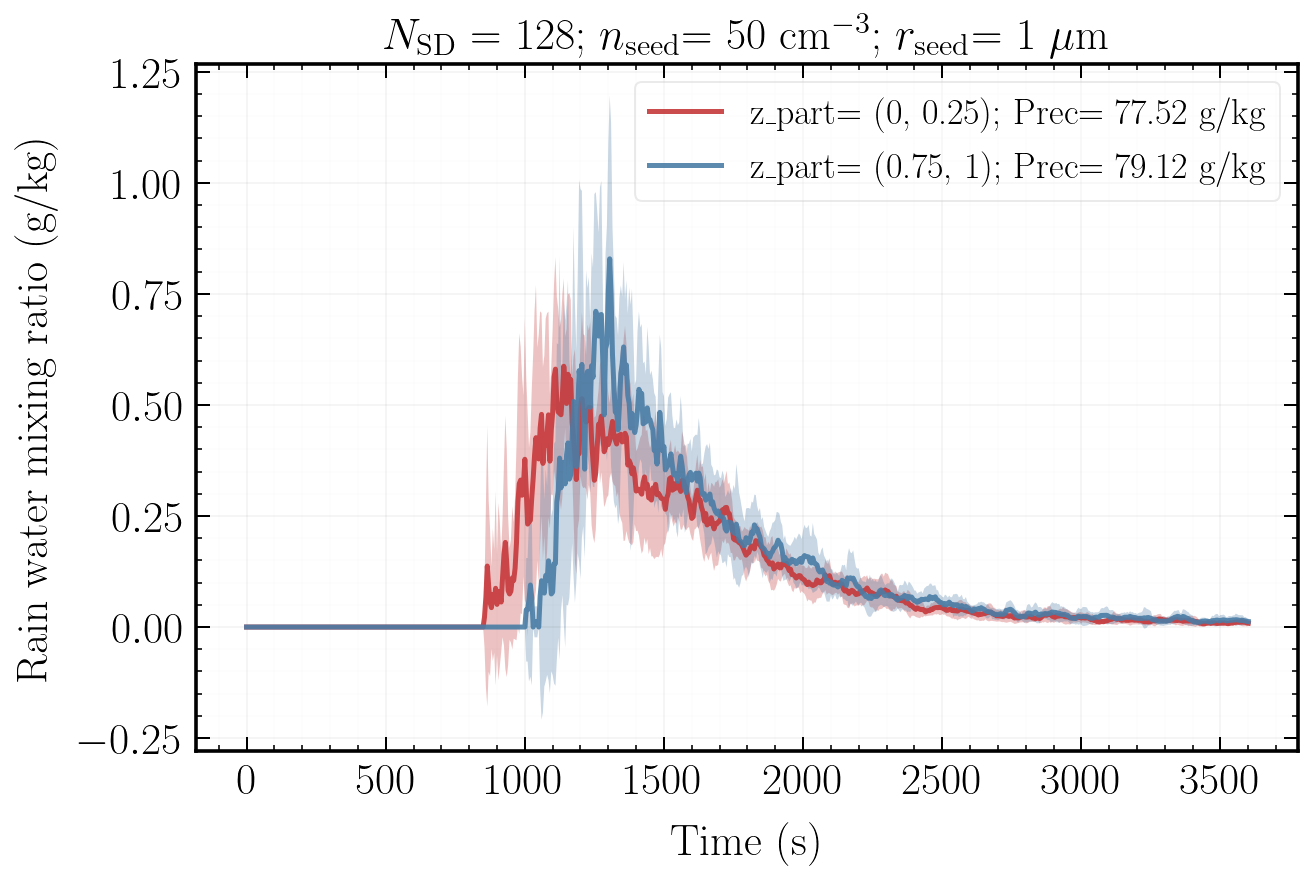

In [14]:
fig, ax= plt.subplots(1, 1, figsize= (9, 6) , constrained_layout= True)

ax.plot(rain_xarr_rhow2_1['t'], rain_xarr_rhow2_1.sel(z= 25).mean(dim= "run").values, label= r'z_part= (0, 0.25); Prec= %.2f g/kg'%np.sum(rain_xarr_rhow2_1.sel(z= 25).mean(dim= "run").values))
ax.fill_between(rain_xarr_rhow2_1.t, rain_xarr_rhow2_1.sel(z= 25).mean(dim= "run") + rain_xarr_rhow2_1.sel(z= 25).std(dim= "run"), \
                                        rain_xarr_rhow2_1.sel(z= 25).mean(dim= "run") - rain_xarr_rhow2_1.sel(z= 25).std(dim= "run"), alpha= 0.3)
ax.plot(rain_xarr_rhow2_2['t'], rain_xarr_rhow2_2.sel(z= 25).mean(dim= "run").values, label= r'z_part= (0.75, 1); Prec= %.2f g/kg'%np.sum(rain_xarr_rhow2_2.sel(z= 25).mean(dim= "run").values))
ax.fill_between(rain_xarr_rhow2_2.t, rain_xarr_rhow2_2.sel(z= 25).mean(dim= "run") + rain_xarr_rhow2_2.sel(z= 25).std(dim= "run"), \
                                        rain_xarr_rhow2_2.sel(z= 25).mean(dim= "run") - rain_xarr_rhow2_2.sel(z= 25).std(dim= "run"), alpha= 0.3)
ax.set_xlabel('Time (s)', fontsize= 22);
ax.set_ylabel('Rain water mixing ratio (g/kg)', fontsize= 22);
ax.legend(loc= 'upper right', frameon= True, fontsize= 18);

ax.set_title(r'$N_{\rm SD}$ = 128; $n_{\rm seed}$= 50 cm$^{-3}$; $r_{\rm seed}$= 1 $\mu$m', fontsize= 22);
#ax.set_title(r'$\rho_w \times w = 2$ kg m$^{3}$ s$^{-1}$', fontsize= 22);
ax.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax.grid(visible=True, which='major', color='black', alpha=0.05, linestyle='-');
ax.grid(visible=True, which='minor', color='black', alpha=0.01, linestyle='-');
#ax[0].text(0.18, 0.8, r'$r = %.2f$'%, fontsize= 22, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
#            transform=ax[0].transAxes)
#plt.savefig('../../plots/surface_rain_n1_50_n2_50_r2_1_zpart_plot.pdf', bbox_inches='tight', dpi= 300);

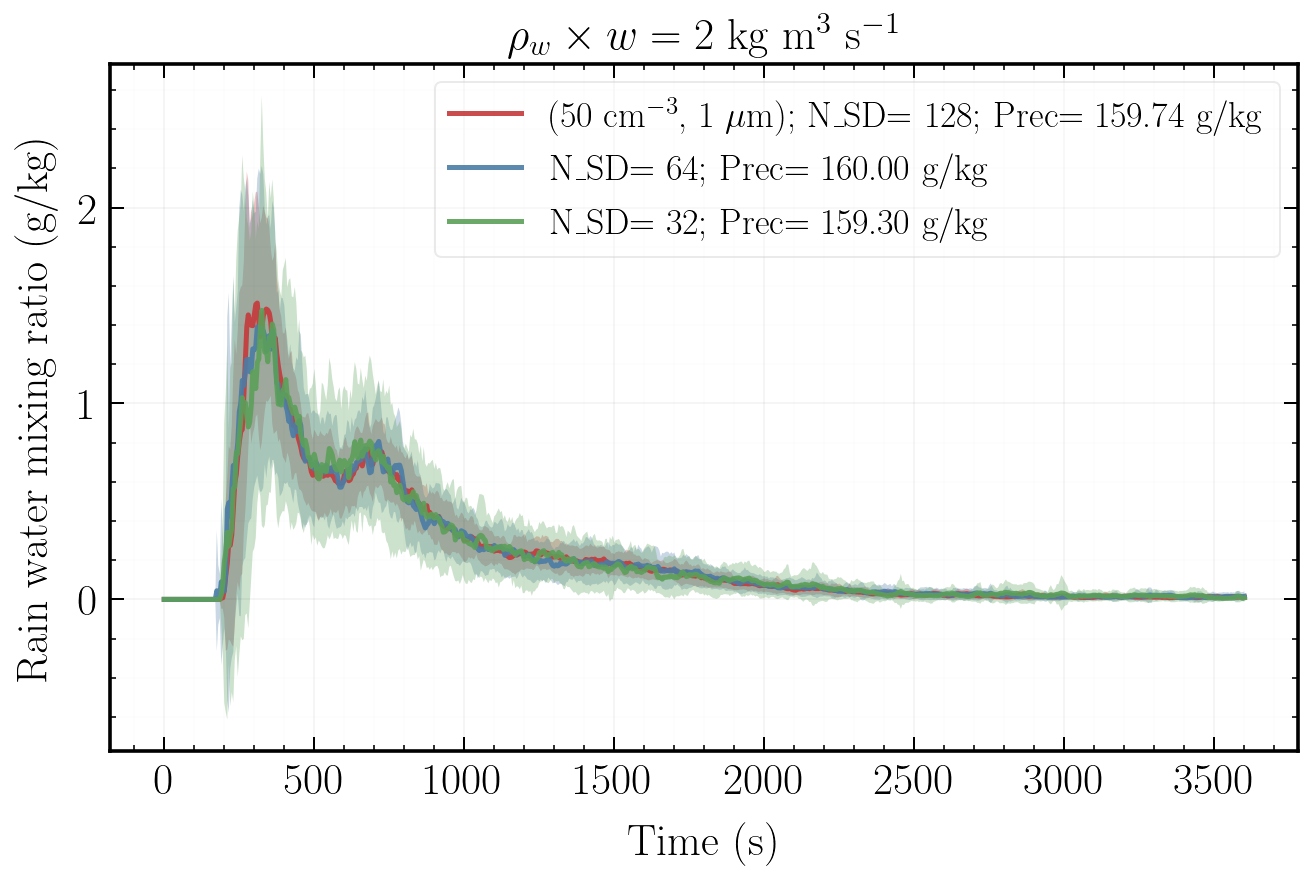

In [29]:
fig, ax= plt.subplots(1, 1, figsize= (9, 6) , constrained_layout= True)

ax.plot(rain_xarr_rhow2_1['t'], rain_xarr_rhow2_1.sel(z= 25).mean(dim= "run").values, label= r'(50 cm$^{-3}$, 1 $\mu$m); N_SD= 128; Prec= %.2f g/kg'%np.sum(rain_xarr_rhow2_1.sel(z= 25).mean(dim= "run").values))
ax.fill_between(rain_xarr_rhow2_1.t, rain_xarr_rhow2_1.sel(z= 25).mean(dim= "run") + rain_xarr_rhow2_1.sel(z= 25).std(dim= "run"), \
                                        rain_xarr_rhow2_1.sel(z= 25).mean(dim= "run") - rain_xarr_rhow2_1.sel(z= 25).std(dim= "run"), alpha= 0.3)
ax.plot(rain_xarr_rhow2_2['t'], rain_xarr_rhow2_2.sel(z= 25).mean(dim= "run").values, label= r' N_SD= 64; Prec= %.2f g/kg'%np.sum(rain_xarr_rhow2_2.sel(z= 25).mean(dim= "run").values))
ax.fill_between(rain_xarr_rhow2_2.t, rain_xarr_rhow2_2.sel(z= 25).mean(dim= "run") + rain_xarr_rhow2_2.sel(z= 25).std(dim= "run"), \
                                        rain_xarr_rhow2_2.sel(z= 25).mean(dim= "run") - rain_xarr_rhow2_2.sel(z= 25).std(dim= "run"), alpha= 0.3)
ax.plot(rain_xarr_rhow2_3['t'], rain_xarr_rhow2_3.sel(z= 25).mean(dim= "run").values, label= r' N_SD= 32; Prec= %.2f g/kg'%np.sum(rain_xarr_rhow2_3.sel(z= 25).mean(dim= "run").values))
ax.fill_between(rain_xarr_rhow2_3.t, rain_xarr_rhow2_3.sel(z= 25).mean(dim= "run") + rain_xarr_rhow2_3.sel(z= 25).std(dim= "run"), \
                                        rain_xarr_rhow2_3.sel(z= 25).mean(dim= "run") - rain_xarr_rhow2_3.sel(z= 25).std(dim= "run"), alpha= 0.3)
ax.set_xlabel('Time (s)', fontsize= 22);
ax.set_ylabel('Rain water mixing ratio (g/kg)', fontsize= 22);
ax.legend(loc= 'upper right', frameon= True, fontsize= 18);

ax.set_title(r'$\rho_w \times w = 2$ kg m$^{3}$ s$^{-1}$', fontsize= 22);
ax.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax.grid(visible=True, which='major', color='black', alpha=0.05, linestyle='-');
ax.grid(visible=True, which='minor', color='black', alpha=0.01, linestyle='-');
#ax[0].text(0.18, 0.8, r'$r = %.2f$'%, fontsize= 22, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
#            transform=ax[0].transAxes)
#plt.savefig('../../plots/surface_rain_rhow=2.0_n1_50_n2_10_50_r2_1.pdf', bbox_inches='tight', dpi= 300);
plt.savefig('../../plots/surface_rain_rhow=2.0_n1_50_n2_50_r2_1_nsd_plot.pdf', bbox_inches='tight', dpi= 300);

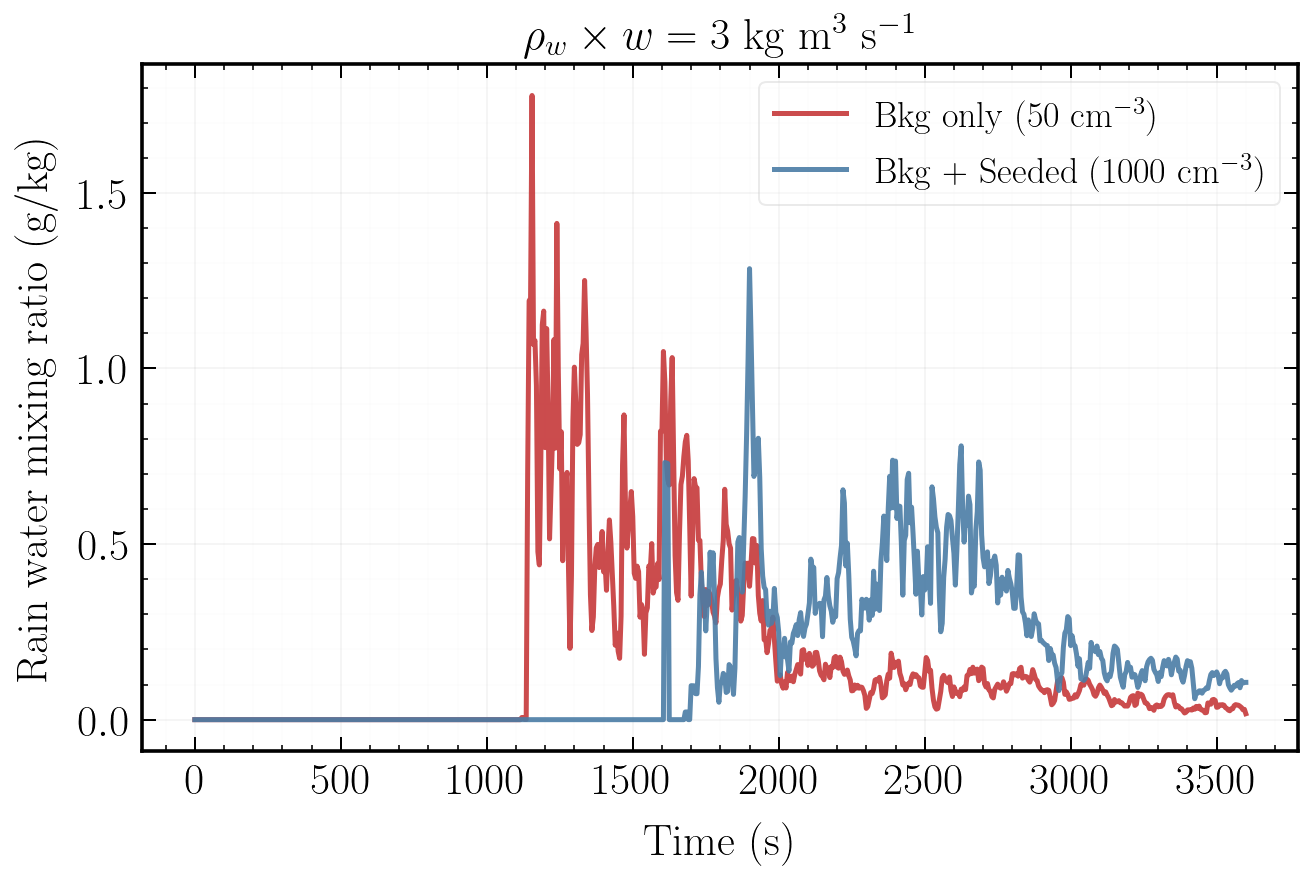

In [14]:
fig, ax= plt.subplots(1, 1, figsize= (9, 6) , constrained_layout= True)

ax.plot(rain_xarr_rhow3_bkg['t'], rain_xarr_rhow3_bkg.sel(z= 25).values, label= r'Bkg only (50 cm$^{-3}$)')
ax.plot(rain_xarr_rhow3_seed['t'], rain_xarr_rhow3_seed_high.sel(z= 25).values, label= r'Bkg + Seeded (1000 cm$^{-3}$)')
ax.set_xlabel('Time (s)', fontsize= 22);
ax.set_ylabel('Rain water mixing ratio (g/kg)', fontsize= 22);
ax.legend(frameon= True, fontsize= 18);

ax.set_title(r'$\rho_w \times w = 3$ kg m$^{3}$ s$^{-1}$', fontsize= 22);
ax.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax.grid(visible=True, which='major', color='black', alpha=0.05, linestyle='-');
ax.grid(visible=True, which='minor', color='black', alpha=0.01, linestyle='-');
plt.savefig('../../plots/rwmr_rhow=3.0_n1_50_n2_1000.pdf', bbox_inches='tight', dpi= 300);

## Experiments

In [53]:
from PySDM.initialisation.sampling import spatial_sampling
from PySDM.backends import CPU

In [56]:
backend= CPU(formulae= settings['rhow=2.0'].formulae)
n_elements= 2336 #simulation['rhow=2.0_run=0'].particulator.n_sd

storage = backend.Storage.empty(n_elements, dtype=float)
backend.Random(seed=backend.formulae.seed, size=n_elements)(storage)
positions = storage.to_ndarray().reshape(1, n_elements)

In [57]:
positions

array([[0.00492393, 0.93663793, 0.54951352, ..., 0.26004327, 0.26284857,
        0.31176501]])

In [37]:
simulation['rhow=2.0_run=0'].mesh._Mesh__strides(simulation['rhow=2.0_run=0'].mesh.grid)

array([[1]])

In [42]:
spatial_discretisation= spatial_sampling.Pseudorandom()

positions= spatial_discretisation.sample(
                backend= CPU(formulae= settings['rhow=2.0_run=0'].formulae),
                grid= simulation['rhow=2.0_run=0'].mesh.grid,
                n_sd= simulation['rhow=2.0_run=0'].particulator.n_sd,
                z_part= (0.25, 0.5)
            )

In [43]:
positions.shape, positions.max()

((1, 18688), 35.99777782979129)

In [44]:
cellid, cellorigin, poscell= simulation['rhow=2.0_run=0'].mesh.cellular_attributes(positions)

In [52]:
cellid

array([20, 28, 32, ..., 29, 18, 20])

In [46]:
cellorigin

array([[20, 28, 32, ..., 29, 18, 20]])

In [55]:
from PySDM.impl import arakawa_c

In [58]:
rhod= settings['rhow=2.0_run=0'].rhod(-settings['rhow=2.0_run=0'].particle_reservoir_depth + simulation['rhow=2.0_run=0'].mesh.dz * arakawa_c.z_scalar_coord(simulation['rhow=2.0_run=0'].mesh.grid))

In [72]:
rhod

array([1.13841558, 1.13841558, 1.13841558, 1.13841558, 1.13841558,
       1.13841558, 1.13841558, 1.13841558, 1.13841558, 1.13841558,
       1.13841558, 1.13841558, 1.13841558, 1.13609352, 1.13152678,
       1.12697057, 1.12242486, 1.11788966, 1.11336496, 1.10885075,
       1.10434703, 1.09985379, 1.09537103, 1.09089875, 1.08643693,
       1.08198558, 1.07754468, 1.07311424, 1.06880766, 1.06455688,
       1.06032095, 1.05609984, 1.05189348, 1.04770182, 1.04352481,
       1.0393624 , 1.03521453, 1.03108115, 1.02696221, 1.02285766,
       1.01876745, 1.01469152, 1.01062982, 1.00658231, 1.00254892,
       0.99852962, 0.99452435, 0.99053306, 0.9865557 , 0.98259222,
       0.97864257, 0.97470671, 0.97078458, 0.96687613, 0.96298133,
       0.9591001 , 0.95523242, 0.95137824, 0.94753749, 0.94371014,
       0.93989614, 0.93609545, 0.93230801, 0.92853377, 0.9247727 ,
       0.92102475, 0.91728987, 0.913568  , 0.90985912, 0.90616317,
       0.90248011, 0.89880989, 0.89515246])

In [61]:
rhod[cellid].shape

(18688,)

In [70]:
arr_A= np.array([1, 2, 3, 4, 5])
arr_B= np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [74]:
z_part= ((0., 1.), (0.1, 0.25))

In [76]:
z_part[0], z_part[1]

((0.0, 1.0), (0.1, 0.25))